https://madewithml.com/courses/foundations/neural-networks/

In [8]:
import numpy as np
import random

SEED = 1234

# Set seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/spiral.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,X1,X2,color
0,0.106737,0.114197,c1
1,0.311513,-0.664028,c1
2,0.019870,-0.703126,c1
3,-0.054017,0.508159,c3
4,-0.127751,-0.011382,c3


In [11]:
# Data shapes
X = df[["X1", "X2"]].values
y = df["color"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


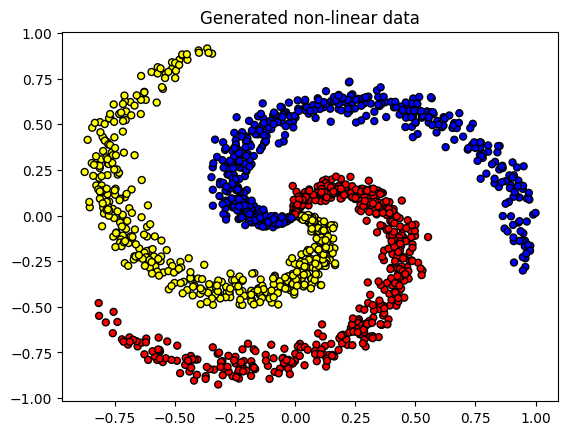

In [12]:
# Visualize data
plt.title("Generated non-linear data")
colors = {"c1": "red", "c2": "yellow", "c3": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors="k", s=25)
plt.show()

In [13]:
import collections
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [14]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [15]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [-0.63919105 -0.69724176] → c1


In [18]:
X_train.shape

(1050, 2)

In [19]:
from sklearn.preprocessing import LabelEncoder

# Output vectorizer
label_encoder = LabelEncoder()

In [20]:
# Fit on train data
label_encoder = label_encoder.fit(y_train)
classes = list(label_encoder.classes_)
print (f"classes: {classes}")

classes: ['c1', 'c2', 'c3']


In [21]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: c1
y_train[0]: 0


In [75]:
y_train, y_train.shape

(array([0, 0, 0, ..., 1, 2, 1]), (1050,))

In [30]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [350 350 350]
weights: {0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


In [31]:
from sklearn.preprocessing import StandardScaler

# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: 0.1, std: 0.9
X_test[1]: mean: 0.0, std: 1.0


In [32]:
import torch

# Set seed for reproducibility
torch.manual_seed(SEED);

### Model

In [33]:
from torch import nn
import torch.nn.functional as F

INPUT_DIM = X_train.shape[1] # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = len(classes) # 3 classes

In [34]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in) # linear activation
        z = self.fc2(z)
        return z

In [35]:
# Initialize model
model = LinearModel(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of LinearModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


### Training

In [36]:
from torch.optim import Adam

LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
BATCH_SIZE = 32

# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [37]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%1==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.13, accuracy: 49.9
Epoch: 1 | loss: 0.91, accuracy: 50.3
Epoch: 2 | loss: 0.79, accuracy: 55.3
Epoch: 3 | loss: 0.74, accuracy: 54.6
Epoch: 4 | loss: 0.74, accuracy: 53.7
Epoch: 5 | loss: 0.75, accuracy: 53.6
Epoch: 6 | loss: 0.76, accuracy: 53.7
Epoch: 7 | loss: 0.77, accuracy: 53.8
Epoch: 8 | loss: 0.77, accuracy: 53.9
Epoch: 9 | loss: 0.78, accuracy: 53.9


### Evaluation

In [38]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [39]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [40]:
# Predictions
y_prob = F.softmax(model(X_test), dim=1)
print (f"sample probability: {y_prob[0]}")
y_pred = y_prob.max(dim=1)[1]
print (f"sample class: {y_pred[0]}")

sample probability: tensor([0.8995, 0.0286, 0.0719], grad_fn=<SelectBackward0>)
sample class: 0


In [41]:
# Performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.5326832791621523,
    "recall": 0.5333333333333333,
    "f1": 0.5327986224880954,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 0.5,
      "recall": 0.5066666666666667,
      "f1": 0.5033112582781457,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 0.5211267605633803,
      "recall": 0.49333333333333335,
      "f1": 0.5068493150684932,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 0.5769230769230769,
      "recall": 0.6,
      "f1": 0.5882352941176471,
      "num_samples": 75.0
    }
  }
}


0: ------> (101, 101) (101, 101)
1: y_pred.shape: torch.Size([10201, 3])
2: y_pred.shape: torch.Size([10201])
3: y_pred.shape: torch.Size([101, 101])
xx.shape: (101, 101), yy.shape: (101, 101)


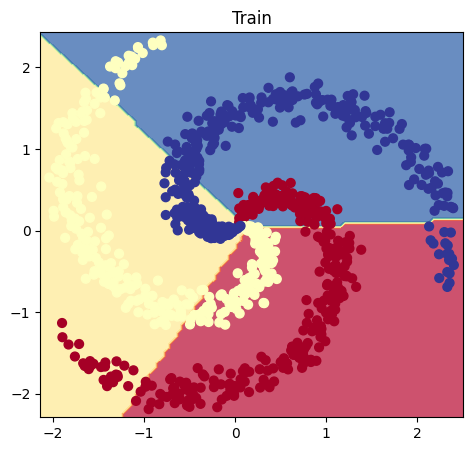

In [45]:
X = X_train
y = y_train
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")

x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

print("0: ------>", xx.shape, yy.shape)
cmap = plt.cm.Spectral
X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
y_pred = F.softmax(model(X_test), dim=1)
print(f"1: y_pred.shape: {y_pred.shape}")
_, y_pred = y_pred.max(dim=1)
print(f"2: y_pred.shape: {y_pred.shape}")
y_pred = y_pred.reshape(xx.shape)
print(f"3: y_pred.shape: {y_pred.shape}")
print(f"xx.shape: {xx.shape}, yy.shape: {yy.shape}")

plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()